Check the code at: https://drive.google.com/drive/u/0/folders/1G8vKjcj3CKgdLIEinw9kNPHbLylZgy7c

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat May 18 17:54:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              48W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Preparation**

In [ ]:
path = "/content/drive/MyDrive/MODEL TRAINING/GRAD THESIS/"

In [ ]:
import pickle
import pandas as pd
df = pd.read_csv(path+'train.csv')
df = df.dropna()

In [ ]:
data_train = df.review.to_list()
label_train = df.label.to_list()

In [ ]:
!pip install --upgrade keras-bert
!pip install -q keras-rectified-adam

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for keras-bert: filename=keras_bert-0.89.0-py3-none-any.whl size=33500 sha256=f60c546c2d33f284b512a207acad6ab3e0bdb283d9040bf53b6c735e4a4a653d
  Stored in directory: /root/.cache/pip/wheels/89/0c/04/646b6fdf6375911b42c8d540a8a3fda8d5d77634e5dcbe7b26
  Created wheel for keras-transformer: filename=keras_transformer-0.40.0-py3-none-any.whl size=12286 sha256=08cf3e572a87d4d7233b49d4d760fc13aede42fa531b740cc2762c8b814589d5
  Stored in directory: /root/.cache/pip/wheels/f2/cb/22/75a0ad376129177f7c95c0d91331a18f5368fd657f4035ba7c
  Created wheel for keras-embed-sim: filename=keras_embed_sim-0.10.0-py3-none-any.whl size=3944 sha256=f387bb8c3d33e8aecd1fb79

In [ ]:
!pip install tensorflow==2.15.0

In [ ]:
!pip install keras==2.15.0

In [ ]:
import codecs
import tensorflow.keras as tf
import keras
import os
from keras import backend as K
from keras_bert import load_trained_model_from_checkpoint
import numpy as np

In [ ]:
SEQ_LEN = 256
BATCH_SIZE = 16
EPOCHS = 10
LR = 2e-5

In [ ]:
!wget -q https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
!unzip -o multi_cased_L-12_H-768_A-12.zip

Archive:  multi_cased_L-12_H-768_A-12.zip
   creating: multi_cased_L-12_H-768_A-12/
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: multi_cased_L-12_H-768_A-12/vocab.txt  
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: multi_cased_L-12_H-768_A-12/bert_config.json  


In [ ]:
pretrained_path = 'multi_cased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

In [ ]:
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    seq_len=SEQ_LEN,
    output_layer_num=4,
    trainable=True
)

In [ ]:
token_dict = {}
with codecs.open(vocab_path, 'rb','utf-8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)

In [ ]:
from keras_bert import Tokenizer
tokenizer = Tokenizer(token_dict,cased=True)

In [ ]:
from keras_bert.layers import Extract
from keras.regularizers import l1
from keras.layers import LSTM,SpatialDropout1D
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.layers import Dense, LSTM, SpatialDropout1D
!pip install --upgrade keras_radam

import keras_bert
from keras.layers import Dense, Input, Flatten,SpatialDropout1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Concatenate, Dropout,GlobalMaxPool1D,Lambda
from keras.models import Model
from keras.layers import Bidirectional,LSTM,GRU


  Preparing metadata (setup.py) ... done
  Created wheel for keras_radam: filename=keras_radam-0.15.0-py3-none-any.whl size=14668 sha256=a1412f1101155fd50b53de8c2c4520ad0fedecb18af572f7321496a8e9f3df8d
  Stored in directory: /root/.cache/pip/wheels/e6/e0/44/3d07c185de530721a196a5368d48f6256233337e2c90159f24
Successfully built keras_radam


In [ ]:
class NonMasking(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(NonMasking, self).__init__(**kwargs)
        self.supports_masking = True

    def build(self, input_shape):
        super(NonMasking, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return None

    def call(self, inputs, mask=None):
        return inputs

    def compute_output_shape(self, input_shape):
        return input_shape

In [ ]:
# Apply the NonMasking layer to the model outputs
bert_out = NonMasking()(model.output)

# Apply SpatialDropout1D
text_embed = SpatialDropout1D(0.2)(bert_out)

# Define left and right shifted embeddings using Lambda layers
l_embedding = Lambda(lambda x: K.concatenate([K.zeros_like(x[:, :1]), x[:, :-1]], axis=1))(text_embed)
r_embedding = Lambda(lambda x: K.concatenate([x[:, 1:], K.zeros_like(x[:, :1])], axis=1))(text_embed)

# Define forward and backward LSTM layers
forward = LSTM(256, return_sequences=True)(l_embedding)
backward = LSTM(256, return_sequences=True, go_backwards=True)(r_embedding)
backward = Lambda(lambda x: K.reverse(x, axes=1))(backward)

# Concatenate forward, original, and backward embeddings
together = Concatenate(axis=2)([forward, text_embed, backward])

# Apply a Conv1D layer followed by a global max pooling layer
semantic = Conv1D(256, kernel_size=1, activation="tanh")(together)
sentence_embed = Lambda(lambda x: K.max(x, axis=1))(semantic)

# Add dense layers for classification
dense_layer = Dense(256, activation='relu')(sentence_embed)
preds = Dense(1, activation='sigmoid')(dense_layer)

# Create and compile the final model
model1 = Model(inputs=model.input, outputs=preds)
model1.compile(loss='binary_crossentropy',
               optimizer=Adam(learning_rate=LR),
               metrics=['accuracy'])

# Ensure the model summary
model1.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input-Token (InputLayer)    [(None, 256)]                0         []                            
                                                                                                  
 Input-Segment (InputLayer)  [(None, 256)]                0         []                            
                                                                                                  
 Embedding-Token (TokenEmbe  [(None, 256, 768),           9181209   ['Input-Token[0][0]']         
 dding)                       (119547, 768)]              6                                       
                                                                                                  
 Embedding-Segment (Embeddi  (None, 256, 768)             1536      ['Input-Segment[0][0]'] 

In [ ]:
from sklearn.model_selection import train_test_split
def load_data(data, sentiments):
    global tokenizer
    indices = []
    for text in data:
      ids, segments = tokenizer.encode(text, max_len=SEQ_LEN)
      indices.append(ids)
    indices = np.array(indices)
    X = {
        'Input-Token': indices,
        'Input-Segment': np.zeros_like(indices)
    }
    return X, np.array(sentiments)

In [ ]:
data_train_,data_valid,label_train_,label_valid = train_test_split(data_train,label_train,test_size=0.2,random_state=48)

In [ ]:
test = pd.read_csv(path+'test.csv')
test = test.dropna()
data_test = test.review.tolist()
label_test = test.label.tolist()

In [ ]:
X_train,Y_train = load_data(data_train_,label_train_)
X_valid,Y_valid = load_data(data_valid,label_valid)
X_test,Y_test = load_data(data_test,label_test)

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(path+'256_checkpoint_rcnn.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model1.fit(X_train,Y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose = 1,validation_data=[X_valid,Y_valid],callbacks=callbacks_list)

Epoch 1/10
766/766 [==============================] - ETA: 0s - loss: 0.2380 - accuracy: 0.9149
Epoch 1: val_accuracy improved from -inf to 0.93538, saving model to /content/drive/MyDrive/GRAD THESIS/256_checkpoint_rcnn.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


766/766 [==============================] - 269s 287ms/step - loss: 0.2380 - accuracy: 0.9149 - val_loss: 0.2091 - val_accuracy: 0.9354
Epoch 2/10
766/766 [==============================] - ETA: 0s - loss: 0.1770 - accuracy: 0.9421
Epoch 2: val_accuracy improved from 0.93538 to 0.93864, saving model to /content/drive/MyDrive/GRAD THESIS/256_checkpoint_rcnn.h5
766/766 [==============================] - 224s 293ms/step - loss: 0.1770 - accuracy: 0.9421 - val_loss: 0.1866 - val_accuracy: 0.9386
Epoch 3/10
766/766 [==============================] - ETA: 0s - loss: 0.1478 - accuracy: 0.9526
Epoch 3: val_accuracy did not improve from 0.93864
766/766 [==============================] - 202s 264ms/step - loss: 0.1478 - accuracy: 0.9526 - val_loss: 0.2171 - val_accuracy: 0.9328
Epoch 4/10
766/766 [==============================] - ETA: 0s - loss: 0.1244 - accuracy: 0.9631
Epoch 4: val_accuracy did not improve from 0.93864
766/766 [==============================] - 201s 263ms/step - loss: 0.1244 -

In [ ]:
model1.load_weights(path+'256_checkpoint_rcnn.h5')

In [ ]:
y_pred = np.round(model1.predict(X_test))

120/120 [==============================] - 22s 143ms/step


In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score, accuracy_score
print(precision_score(Y_test,y_pred))
print(recall_score(Y_test,y_pred))
print(f1_score(Y_test,y_pred))
print(accuracy_score(Y_test,y_pred))

0.9275261324041811
0.8659726740403383
0.895693135935397
0.9190600522193212


In [ ]:
from sklearn.metrics import classification_report
report=classification_report(Y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2293
           1       0.93      0.87      0.90      1537

    accuracy                           0.92      3830
   macro avg       0.92      0.91      0.91      3830
weighted avg       0.92      0.92      0.92      3830



In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import itertools
matplotlib.rcParams.update({'font.size': 16})
labels = [0,1]
cn = confusion_matrix(Y_test,y_pred,labels=labels)

In [ ]:
#@title plot confusion matrix
def plot_confusion_matrix(cm,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          target_names=None,
                          path_file='1.svg'):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path_file,format='svg')
    plt.show()

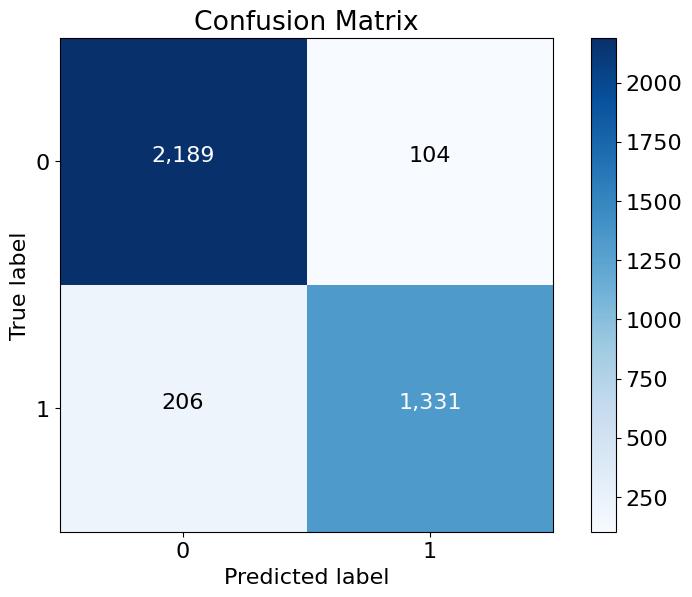

In [ ]:
plot_confusion_matrix(cn,title='Confusion Matrix',normalize=False,target_names=labels,path_file=path+'bert_rcnn.svg')

**Loss Curve**

In [ ]:
def plot_loss_curve(history):
  # Extracting loss and validation loss from training history
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Generating range of epochs
  epochs = range(1, len(loss) + 1)

  # Plotting training and validation loss curve
  plt.plot(epochs, loss, 'y', label = 'Training loss')
  plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
  plt.title('Loss Curve')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

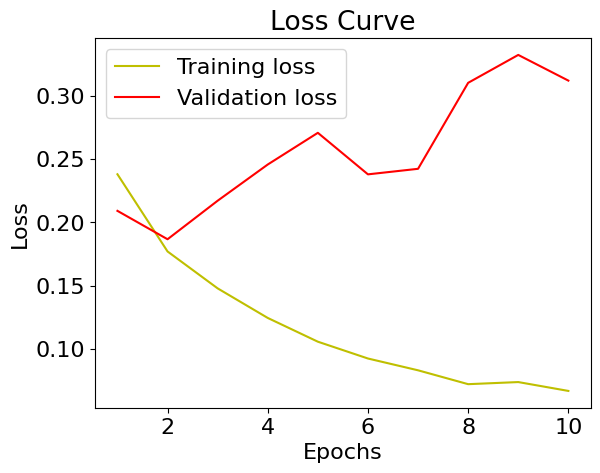

In [ ]:
plot_loss_curve(history)

**Accuracy Curve**

In [ ]:
def plot_accuracy_curve(history):
  # Extracting accuracy and validation accuracy from training history
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  # Generating range of epochs
  epochs = range(1, len(accuracy) + 1)

  # Plotting training and validation accuracy curve
  plt.plot(epochs, accuracy, 'y', label = 'Training accuracy')
  plt.plot(epochs, val_accuracy, 'r', label = 'Validation accuracy')
  plt.title('Accuracy Curve')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

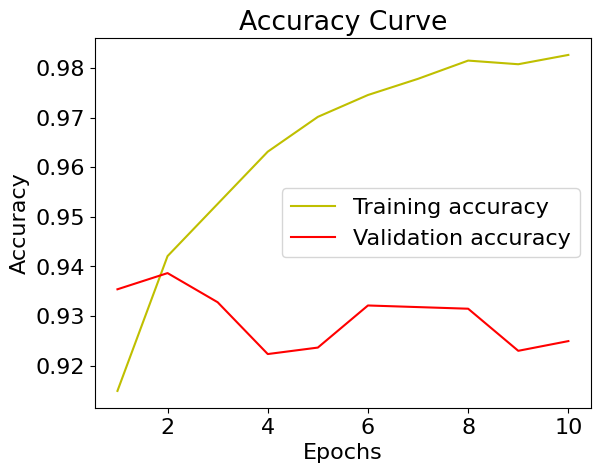

In [ ]:
plot_accuracy_curve(history)

**ROC Curve**

In [ ]:
# Step 1: Make Predictions
y_pred_proba = model1.predict(X_test)

120/120 [==============================] - 17s 143ms/step


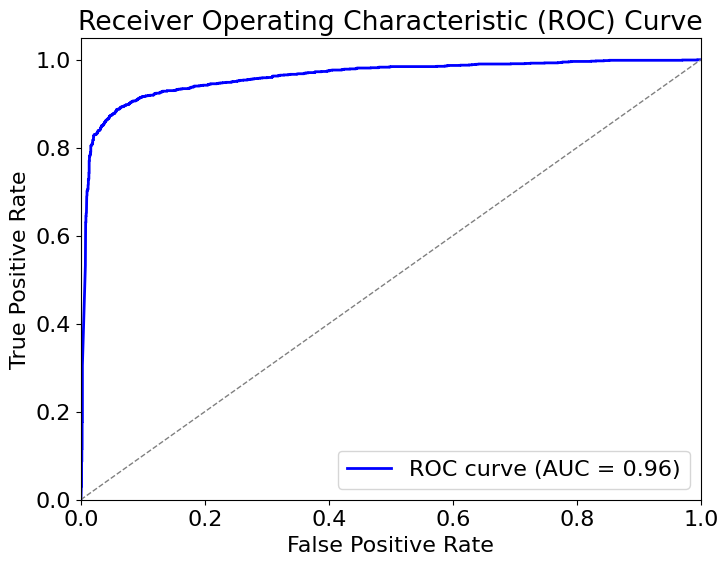

In [ ]:
from sklearn.metrics import roc_curve, auc

# Step 2: Compute ROC Curve
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba)

# Step 3: Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
for i in range(100):
  if y_pred[i]!=Y_test[i]:
    print(y_pred[i],Y_test[i])
    print(data_test[i])

[1.] 0
gui ma nha may positive ko
[0.] 1
kg nhan otp bang tin nhan được
[1.] 0
cho thêm nh đông đi
[0.] 1
mình chỉ chuyên_dùng momo nhưng hôm_nay app lỗi negative vào là bị negative out ra ngoài thế_là mình lại đi ngâm cứu zalo pay thấy cũng nhiều ưu_đãi
[1.] 0
quate
[1.] 0
thanh_toán luôn gặp vấn_đề
[0.] 1
negative negative negative
[1.] 0
liên_kết tài_khoản ngân_hàng không được positive ad
[1.] 0
momo hay bi tinh trang không dang nhap được positive co bao tri thi cung phai bao cho nguoi su dung dv biet truoc va fai co thoi gian nao bao tri hoan thanh chu
[0.] 1
khó lúc nhận mã
[0.] 1
momo dạo nầy lỗi negative nhiều quá cần khắc_phục ngay
